In [11]:
import pandas as pd
import catboost 
import sklearn 
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
import shap
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('../data/processed/cleaned_data.csv', sep=',')
X = data.drop('Preis', axis=1)
y = data['Preis']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [14]:
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=cat_features)

In [15]:
# # mit bezeichnung und ausreiser
best_params = {
    'depth': 6,
    'learning_rate': 0.25552573774921805,
    'iterations': 598,
    'l2_leaf_reg': 1.2219858759157394,
    'bagging_temperature': 0.33587442182902427,
    'random_strength': 3.1012551052358535,
    'loss_function': 'RMSE',
    'verbose': False
}

best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train, cat_features=cat_features)

preds = best_model.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
mean_absolute_error = mean_absolute_error(y_test, preds)
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)
feature = best_model.get_feature_importance(prettified=True)
print(feature)

Mean Absolute Error: 4.32094621542514
Mean Squared Error: 166.55512993223746
R2 Score: 0.5688308884954896
                              Feature Id  Importances
0                   Bauteilgewicht in kg    41.267656
1   Gesamtlänge aller Aussparungen in mm    22.102177
2                                Bereich     7.821222
3                                Flaeche     7.806017
4                 Anzahl der Abkantungen     7.176811
5          Breite Laserzuschnitt in mm 1     5.229998
6                               Material     4.562275
7          Breite Laserzuschnitt in mm 2     2.249083
8                                 Dichte     1.027643
9                    Materialsärke in mm     0.701508
10                           Bezeichnung     0.051884
11                          Bezugsquelle     0.003725


✅ Eingabedaten geladen:
  Bereich Bezeichnung         Bezugsquelle  Breite Laserzuschnitt in mm 1  \
0       A    Anschlag  Eigenfertigungsteil                          194.3   

   Breite Laserzuschnitt in mm 2  Bauteilgewicht in kg  Materialsärke in mm  \
0                           80.0                  0.74                  6.0   

  Material  Anzahl der Abkantungen  Gesamtlänge aller Aussparungen in mm  \
0   S355MC                       4                                 109.9   

   Flaeche     Dichte  
0  15544.0  47.606794  

🔮 Vorhersage (z. B. Preis/Kosten): 2.06

📊 SHAP-Werte für diese Vorhersage:
                                 Feature                 Wert  SHAP-Wert
3          Breite Laserzuschnitt in mm 1                194.3  -2.492804
5                   Bauteilgewicht in kg                 0.74  -2.460102
0                                Bereich                    A  -1.697583
9   Gesamtlänge aller Aussparungen in mm                109.9  -1.226408
8                 A

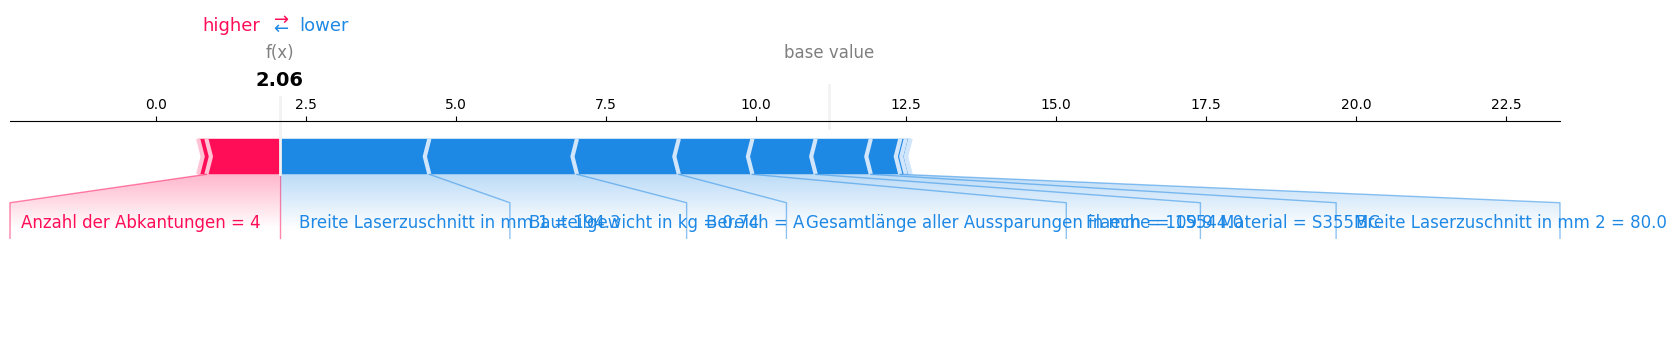

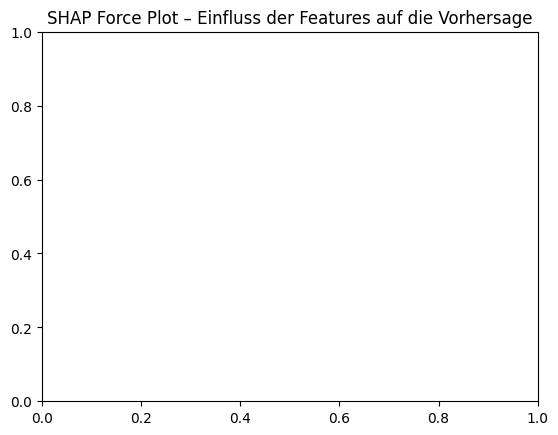

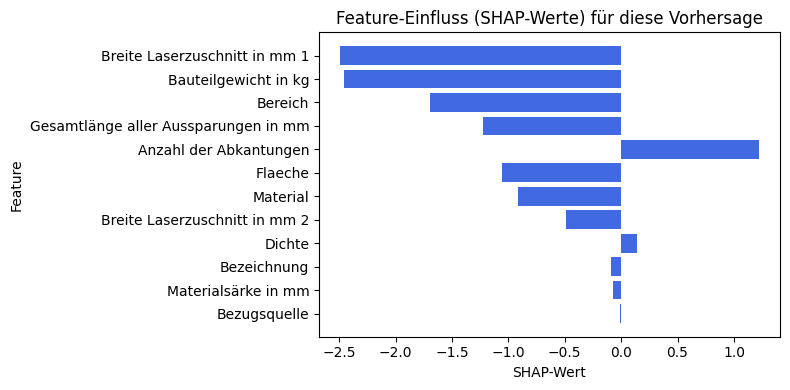

In [16]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ---- 1️⃣ Eingabedatei laden ----
# Datei: "data_input.csv" (oder "data input file", wie du geschrieben hast)
input_df = pd.read_csv('../data/input/cleaned_data.csv', sep=',')

# Sicherstellen, dass Spaltennamen zu X_train passen
# -> ggf. gleiche Reihenfolge erzwingen
input_df = input_df[X_train.columns]

print("✅ Eingabedaten geladen:")
print(input_df)

# ---- 2️⃣ Prediction ----
prediction = best_model.predict(input_df)[0]
print(f"\n🔮 Vorhersage (z. B. Preis/Kosten): {prediction:.2f}")

# ---- 3️⃣ SHAP-Analyse ----
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(input_df)

# ---- 4️⃣ SHAP-Werte tabellarisch anzeigen ----
shap_df = pd.DataFrame({
    'Feature': input_df.columns,
    'Wert': input_df.iloc[0].values,
    'SHAP-Wert': shap_values[0]
}).sort_values('SHAP-Wert', key=abs, ascending=False)

print("\n📊 SHAP-Werte für diese Vorhersage:")
print(shap_df)

# ---- 5️⃣ Force Plot ----
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    input_df,
    matplotlib=True
)
plt.title("SHAP Force Plot – Einfluss der Features auf die Vorhersage")
plt.show()

# ---- 6️⃣ Barplot (Feature-Einfluss) ----
plt.figure(figsize=(8,4))
plt.barh(shap_df['Feature'], shap_df['SHAP-Wert'], color='royalblue')
plt.title("Feature-Einfluss (SHAP-Werte) für diese Vorhersage")
plt.xlabel("SHAP-Wert")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
